<a href="https://colab.research.google.com/github/JosephAyo/spam-prs/blob/main/Jupyter_Notebook_Code_for_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!
Initial number of rows: 635
First 5 rows of the dataset:
                                 id repository_name_with_owner  \
0  MDExOlB1bGxSZXF1ZXN0MTEwODkyMDI2           MolSSI/QCFractal   
1  MDExOlB1bGxSZXF1ZXN0MTc0NDMxODk5           MolSSI/QCFractal   
2  MDExOlB1bGxSZXF1ZXN0MjE0MDQ2MDMx           MolSSI/QCFractal   
3  MDExOlB1bGxSZXF1ZXN0MjEzNjk4NDkw           MolSSI/QCFractal   
4  MDExOlB1bGxSZXF1ZXN0MjEzNjYwMTc5           MolSSI/QCFractal   

                                           url            created_at  \
0   https://github.com/MolSSI/QCFractal/pull/2  2017-03-15T16:54:45Z   
1   https://github.com/MolSSI/QCFractal/pull/3  2018-03-12T16:57:40Z   
2  https://github.com/MolSSI/QCFractal/pull/48  2018-09-07T21:40:00Z   
3  https://github.com/MolSSI/QCFractal/pull/47  2018-09-06T17:47:05Z   
4  https://github.com/MolSSI

<ipython-input-41-edbe46bfa182>:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='zerogpt_label', data=df, palette='viridis')


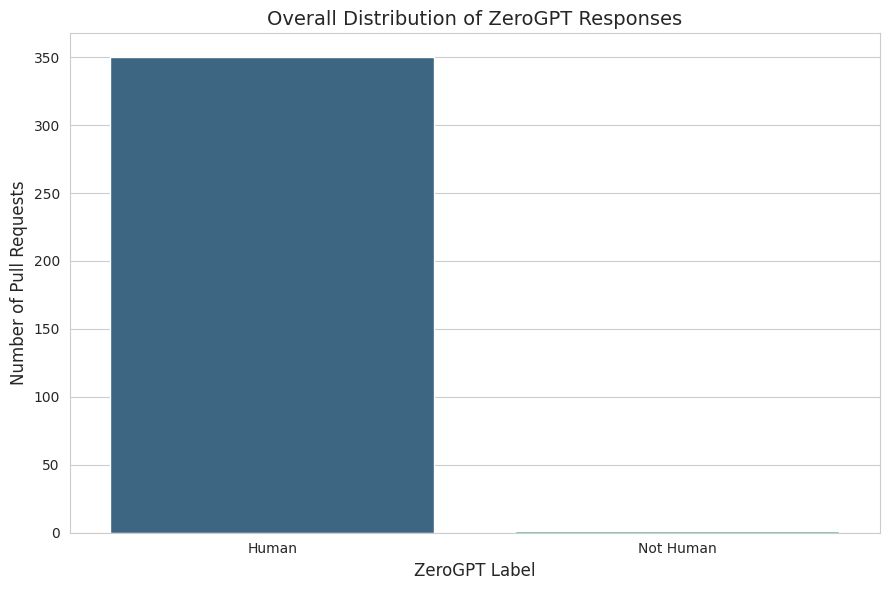

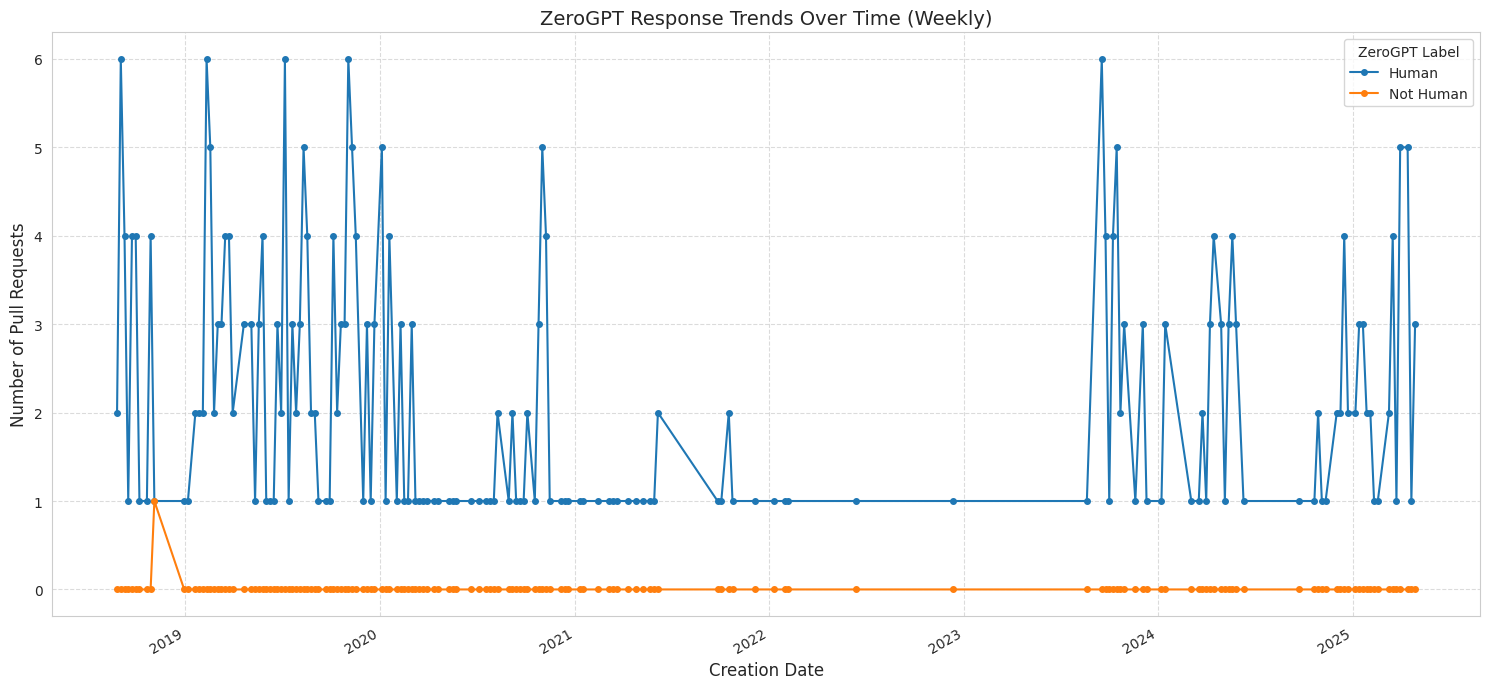

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json # Import the json library for parsing

# Load the dataset
# Make sure 'molssi__qcfractal-detection.csv' is in the same directory as your notebook,
# or provide the full path to the file.

# --- Google Colab Specific: Mount Google Drive ---
# If running in Google Colab, uncomment the following lines to mount your Google Drive.
# This will will allow you to access files stored in your Drive.
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your file in Google Drive
# Replace 'My Drive/your_folder/molssi__qcfractal-detection.csv' with the actual path
# to your file within your Google Drive.
file_path = '/content/drive/My Drive/zero-ai/molssi__qcfractal-detection.csv' # Example path

try:
    # Use the file_path variable for loading the CSV
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print(f"Initial number of rows: {len(df)}")
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nColumns in the dataset:")
    print(df.columns.tolist())
except FileNotFoundError:
    print(f"Error: '{file_path}' not found.")
    print("Please ensure the CSV file is in the specified Google Drive path and Drive is mounted.")
    exit() # Exit if the file is not found

# --- Data Preprocessing ---

# 1. Convert 'created_at' to datetime objects
# This is crucial for time-based analysis.
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Drop rows where 'created_at' could not be parsed (if any)
df.dropna(subset=['created_at'], inplace=True)
print(f"\nNumber of rows after dropping invalid 'created_at' dates: {len(df)}")

# Remove rows where 'zerogpt_response' is missing or NaN
df.dropna(subset=['zerogpt_response'], inplace=True)
print(f"Number of rows after dropping missing 'zerogpt_response' values: {len(df)}")


# 2. Categorize 'zerogpt_response' by parsing JSON
# We'll parse the 'zerogpt_response' JSON to extract 'isHuman' and 'fakePercentage'
# and then use 'fakePercentage' to label as 'Human' or 'Not Human'.

def parse_zerogpt_response(response_str):
    """
    Parses a JSON string from 'zerogpt_response' and extracts 'isHuman' and 'fakePercentage'.
    Returns (isHuman, fakePercentage) or (None, None) if parsing fails or keys are missing.
    Explicitly returns (None, None) if the 'data' dictionary is empty.
    """
    try:
        if pd.isna(response_str):
            return None, None
        response_json = json.loads(response_str)
        data = response_json.get('data', {})

        # Explicitly check if 'data' is an empty dictionary
        if not data: # This covers cases where 'data' is missing or an empty object
            return None, None

        additional_feedback = data.get('additional_feedback', '')
        if additional_feedback and additional_feedback == "Please input more text for a more accurate result":
            return None, None

        is_human = data.get('isHuman')
        fake_percentage = data.get('fakePercentage')
        return is_human, fake_percentage
    except (json.JSONDecodeError, AttributeError, TypeError):
        return None, None # Return None for both if parsing fails

# Apply the parsing function and create new columns
df[['parsed_isHuman', 'parsed_fakePercentage']] = df['zerogpt_response'].apply(
    lambda x: pd.Series(parse_zerogpt_response(x))
)

# --- NEW: Remove rows where parsing failed (i.e., parsed_isHuman or parsed_fakePercentage are None) ---
initial_rows_before_parsing_dropna = len(df)
df.dropna(subset=['parsed_isHuman', 'parsed_fakePercentage'], inplace=True)
print(f"Number of rows after dropping entries with unparseable/empty 'zerogpt_response' data: {len(df)} (Removed {initial_rows_before_parsing_dropna - len(df)} rows)")


# Define 'zerogpt_label' based on 'parsed_fakePercentage'
# We'll consider a response "Not Human" if fakePercentage is greater than 50.0%
# Since we dropped rows with NaN parsed_fakePercentage, 'Unknown' label should now be rare or absent.
df['zerogpt_label'] = df['parsed_fakePercentage'].apply(
    lambda x: 'Not Human' if x > 50.0 else 'Human'
)

print("\nValue counts for 'zerogpt_label' after JSON parsing and cleaning:")
print(df['zerogpt_label'].value_counts())
print("\nFirst 5 rows with new parsed columns and zerogpt_label:")
print(df[['zerogpt_response', 'parsed_isHuman', 'parsed_fakePercentage', 'zerogpt_label']].head())

# --- PR IDs for 'Unknown' ZeroGPT Labels ---
print("\n--- PR IDs for 'Unknown' ZeroGPT Labels ---")
unknown_prs = df[df['zerogpt_label'] == 'Not Human']
if not unknown_prs.empty:
    # Assuming 'id' is the column containing the PR IDs.
    # If your PR ID column has a different name, please replace 'id' below.
    if 'id' in unknown_prs.columns:
        print(unknown_prs['id'])
    else:
        print("Warning: 'id' column not found in the DataFrame. Cannot list PR IDs.")
        print("Available columns:", unknown_prs.columns.tolist())
else:
    print("No entries found with 'Unknown' ZeroGPT label.")
print("--- End PR IDs for 'Unknown' ZeroGPT Labels ---")


# --- Data Visualization ---

# Set a style for the plots for better aesthetics
sns.set_style("whitegrid")

# 1. Distribution of Human vs. Not Human responses
plt.figure(figsize=(9, 6)) # Create a new figure for the first plot
sns.countplot(x='zerogpt_label', data=df, palette='viridis')
plt.title('Overall Distribution of ZeroGPT Responses', fontsize=14)
plt.xlabel('ZeroGPT Label', fontsize=12)
plt.ylabel('Number of Pull Requests', fontsize=12)
plt.tight_layout()
plt.show() # Show the first plot

# 2. Time series analysis: Number of Human vs. Not Human responses over time
# We'll resample the data by week to see trends.
# Corrected approach: Group by week and then unstack 'zerogpt_label' to make them columns
df_weekly_counts = df.groupby([pd.Grouper(key='created_at', freq='W'), 'zerogpt_label']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 7)) # Create a new figure for the second plot

# Check if df_weekly_counts is empty before attempting to plot
if df_weekly_counts.empty:
    print("\nWarning: df_weekly_counts is empty. No time series data to plot.")
    plt.text(0.5, 0.5, "No time series data to plot.\nCheck console output for debugging info.",
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
             fontsize=12, color='red')
else:
    # Plotting 'Human' and 'Not Human' as separate lines using pandas plot
    # This automatically handles the datetime index and creates lines for each column
    df_weekly_counts.plot(kind='line', ax=plt.gca(), marker='o', markersize=4, linewidth=1.5)

    plt.title('ZeroGPT Response Trends Over Time (Weekly)', fontsize=14)
    plt.xlabel('Creation Date', fontsize=12)
    plt.ylabel('Number of Pull Requests', fontsize=12)
    plt.legend(title='ZeroGPT Label')
    plt.grid(True, linestyle='--', alpha=0.7) # Add grid for better readability

plt.tight_layout()
plt.show() # Show the second plot
